In [215]:
from mesa import Agent, Model
import matplotlib.pyplot as plt
import numpy as np

In [216]:
agent_expectations = {
    "Residents (Positive)": {"Transparency": 0.4, "Inclusivity": 0.4, "Accountability": 0.3, "Outcome Fairness": 0.4},
    "Residents (Neutral)": {"Transparency": 0.6, "Inclusivity": 0.6, "Accountability": 0.5, "Outcome Fairness": 0.5},
    "Residents (Negative)": {"Transparency": 0.9, "Inclusivity": 0.9, "Accountability": 0.9, "Outcome Fairness": 0.6},
    "NGOs": {"Transparency": 0.8, "Inclusivity": 0.8, "Accountability": 0.6, "Outcome Fairness": 0.3},
    "Marginalized Groups": {"Transparency": 0.7, "Inclusivity": 0.9, "Accountability": 0.4, "Outcome Fairness": 0.4}
}

# sequences
sequence_events = {
    "Maximal Effort Process": [
        "Early public consultation",
        "Excursion",
        "Consultation: technology",
        "Consultation: nuisance and health",
        "Consultation: ecological impacts",
        "Consultation: noise and safety",
        "Consultation: commercial developer",
        "Consultation: local ownership",
        "Consultation: financial participation",
        "Consultation: external safety",
        "Consultation: Board authority",
        "Policy proposal",
        "Policy revision",
        "Public consultation",
        "Final decision"
    ],
    "Moderate Effort Process": [
        "Early public consultation",
        "Excursion",
        "Consultation: nuisance and health",
        "Consultation: financial participation",
        "Consultation: Board authority",
        "Policy proposal",
        "Public consultation",
        "Policy revision",
        "Final decision"
    ],
    "Basic Effort Process": [
        "Excursion",
        "Consultation: technology",
        "Policy proposal",
        "Public consultation",
        "Final decision"
    ],
    "Minimal Effort Process": [
        "Policy proposal",
        "Final decision"
    ]
}

event_impact = {
    "Early public consultation": {"Transparency": 0.9, "Inclusivity": 0.9},
    "Excursion": {"Transparency": 0.5, "Inclusivity": 0.4},
    "Consultation: technology": {"Transparency": 0.6, "Inclusivity": 0.5},
    "Consultation: nuisance and health": {"Transparency": 0.6, "Inclusivity": 0.6},
    "Consultation: ecological impacts": {"Transparency": 0.7, "Inclusivity": 0.6},
    "Consultation: noise and safety": {"Transparency": 0.7, "Inclusivity": 0.6},
    "Consultation: commercial developer": {"Transparency": 0.5, "Inclusivity": 0.4},
    "Consultation: local ownership": {"Inclusivity": 0.8, "Outcome Fairness": 0.7},
    "Consultation: financial participation": {"Outcome Fairness": 0.9, "Inclusivity": 0.7},
    "Consultation: external safety": {"Transparency": 0.7, "Accountability": 0.5},
    "Consultation: Board authority": {"Accountability": 0.6, "Transparency": 0.6},
    "Policy proposal": {"Accountability": 0.4},
    "Policy revision": {"Accountability": 0.8, "Outcome Fairness": 0.9},
    "Public consultation": {"Transparency": 0.9, "Inclusivity": 0.9},
    "Final decision": {"Outcome Fairness": 0.6},
}

topic_weights = {
    "Residents (Positive)": {"health": 0.2, "noise": 0.2, "ownership": 0.2, "participation": 0.4},
    "Residents (Neutral)": {"health": 0.3, "noise": 0.3, "ownership": 0.2, "participation": 0.2},
    "Residents (Negative)": {"health": 0.4, "noise": 0.4, "ownership": 0.1, "participation": 0.1},
    "NGOs": {"ecology": 0.4, "transparency": 0.3, "participation": 0.3},
    "Marginalized Groups": {"inclusivity": 0.5, "ownership": 0.2, "participation": 0.3}
}

event_topics = {
    "Early public consultation": ["participation"],
    "Excursion": ["participation"],
    "Consultation: technology": ["transparency"],
    "Consultation: nuisance and health": ["health"],
    "Consultation: ecological impacts": ["ecology"],
    "Consultation: noise and safety": ["noise"],
    "Consultation: commercial developer": ["transparency"],
    "Consultation: local ownership": ["ownership"],
    "Consultation: financial participation": ["ownership"],
    "Consultation: external safety": ["health"],
    "Consultation: Board authority": ["transparency"],
    "Policy proposal": ["transparency"],
    "Policy revision": ["ownership"],
    "Public consultation": ["participation", "inclusivity"],
    "Final decision": ["ownership"]
}


In [217]:
# stakholder agent class

class StakeholderAgent(Agent):
    def __init__(self, unique_id, model, stakeholder_type):
        super().__init__(model)
        self.unique_id = unique_id
        self.stakeholder_type = stakeholder_type
        self.perceptions = {}
        self.reactions = {}

    def calculate_perceptions(self):
        expectations = agent_expectations[self.stakeholder_type]
        max_events = max(len(events) for events in self.model.sequence_events.values())

        for sequence, events in self.model.sequence_events.items():
            actual_scores = {"Transparency": 0, "Inclusivity": 0, "Accountability": 0, "Outcome Fairness": 0}
            dimension_counts = {"Transparency": 0, "Inclusivity": 0, "Accountability": 0, "Outcome Fairness": 0}

            # sum impacts per dimension
            for event in events:
                impacts = self.model.event_impact.get(event, {})
                for dim in impacts:
                    actual_scores[dim] += impacts[dim]
                    dimension_counts[dim] += 1

            # penalties for missing procedural steps
            if "Policy proposal" in events:
                proposal_index = events.index("Policy proposal")
                found_consultation = any(e in ["Public consultation", "Early public consultation"] for e in events[:proposal_index])
                if not found_consultation:
                    actual_scores["Transparency"] -= 0.5
                    actual_scores["Inclusivity"] -= 0.5

            if "Policy revision" not in events:
                actual_scores["Accountability"] -= 0.5
                actual_scores["Outcome Fairness"] -= 0.5

            # average dimension scores
            addressed_dims = 0
            for dim in actual_scores:
                if dimension_counts[dim] > 0:
                    actual_scores[dim] /= dimension_counts[dim]
                    addressed_dims += 1
                else:
                    actual_scores[dim] = 0

                actual_scores[dim] = max(0, min(actual_scores[dim], 1))

            # penalties for expectations not met
            total_penalty = 0
            for dim in expectations:
                if actual_scores[dim] >= expectations[dim]:
                    penalty = 0
                else:
                    penalty = (expectations[dim] - actual_scores[dim]) ** 2
                total_penalty += penalty

            justice_score = 1 - (total_penalty / len(expectations))

            # coverage and sequence length factor
            coverage_factor = addressed_dims / len(expectations)
            sequence_length_factor = len(events) / max_events
            justice_score *= coverage_factor * sequence_length_factor
            justice_score = round(max(0, min(justice_score, 1)), 3)

            self.perceptions[sequence] = justice_score

            if justice_score >= 0.7:
                self.reactions[sequence] = "Support"
            elif justice_score >= 0.4:
                self.reactions[sequence] = "Neutral"
            else:
                self.reactions[sequence] = "Oppose"


    # model class
    
class JusticeModel(Model):
    def __init__(self):
        super().__init__()
        self.stakeholders = []
        self.sequence_events = sequence_events
        self.event_impact = event_impact

        agent_types = list(agent_expectations.keys())
        for i, name in enumerate(agent_types):
            agent = StakeholderAgent(i, self, name)
            self.stakeholders.append(agent)

    def step(self):
        for agent in self.stakeholders:
            agent.calculate_perceptions()



Residents (Positive)
  Maximal Effort Process: score = 1.0, reaction = (Support)
  Moderate Effort Process: score = 0.6, reaction = (Neutral)
  Basic Effort Process: score = 0.318, reaction = (Oppose)
  Minimal Effort Process: score = 0.058, reaction = (Oppose)

Residents (Neutral)
  Maximal Effort Process: score = 1.0, reaction = (Support)
  Moderate Effort Process: score = 0.6, reaction = (Neutral)
  Basic Effort Process: score = 0.296, reaction = (Oppose)
  Minimal Effort Process: score = 0.048, reaction = (Oppose)

Residents (Negative)
  Maximal Effort Process: score = 0.943, reaction = (Support)
  Moderate Effort Process: score = 0.575, reaction = (Neutral)
  Basic Effort Process: score = 0.214, reaction = (Oppose)
  Minimal Effort Process: score = 0.022, reaction = (Oppose)

NGOs
  Maximal Effort Process: score = 0.989, reaction = (Support)
  Moderate Effort Process: score = 0.597, reaction = (Neutral)
  Basic Effort Process: score = 0.281, reaction = (Oppose)
  Minimal Effort P

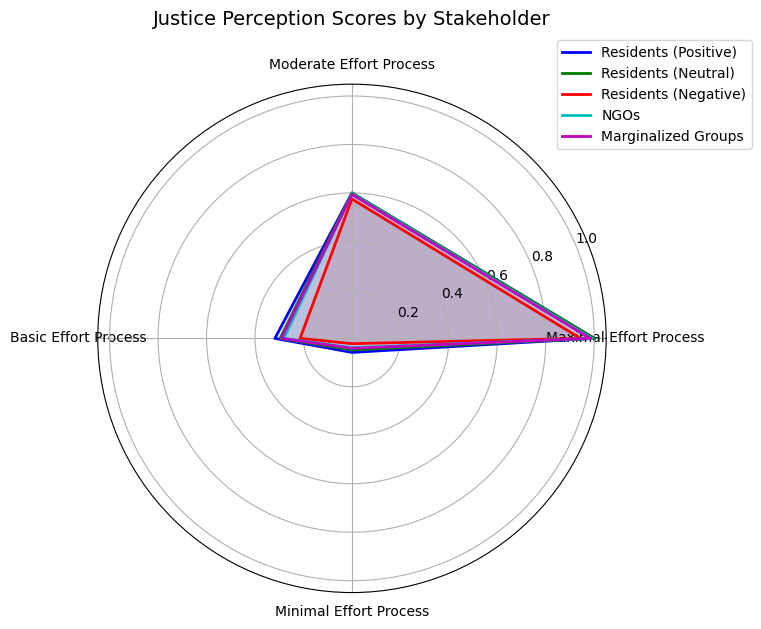

In [218]:
# run model
model = JusticeModel()
model.step()

# output
for agent in model.stakeholders:
    print(f"\n{agent.stakeholder_type}")
    for sequence in sequence_events:
        score = agent.perceptions[sequence]
        reaction = agent.reactions[sequence]
        print(f"  {sequence}: score = {score}, reaction = ({reaction})")

# visualization
sequence_labels = ["Maximal Effort Process", "Moderate Effort Process", "Basic Effort Process", "Minimal Effort Process"]
num_sequences = len(sequence_labels)

# set angles
angles = np.linspace(0, 2 * np.pi, num_sequences, endpoint=False).tolist()
angles += angles[:1]  # close the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, agent in enumerate(model.stakeholders):
    scores = [agent.perceptions[seq] for seq in sequence_labels]
    scores += scores[:1]  # repeat first value to close the plot
    ax.plot(angles, scores, label=agent.stakeholder_type, color=colors[i % len(colors)], linewidth=2)
    ax.fill(angles, scores, alpha=0.1, color=colors[i % len(colors)])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(sequence_labels)

# Add y-axis labels
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])

# Add title and legend
ax.set_title("Justice Perception Scores by Stakeholder", size=14, y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()